# Answer Sheet

In [1]:
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt

from Plot import plot_img, plot_cv

In [2]:
path = "../../../Data/exams/AI-HR01.jpg"
img_rgb = cv.imread(path, cv.IMREAD_COLOR_RGB)
img = cv.cvtColor(img_rgb, cv.COLOR_RGB2GRAY)
img.shape

(3276, 2552)

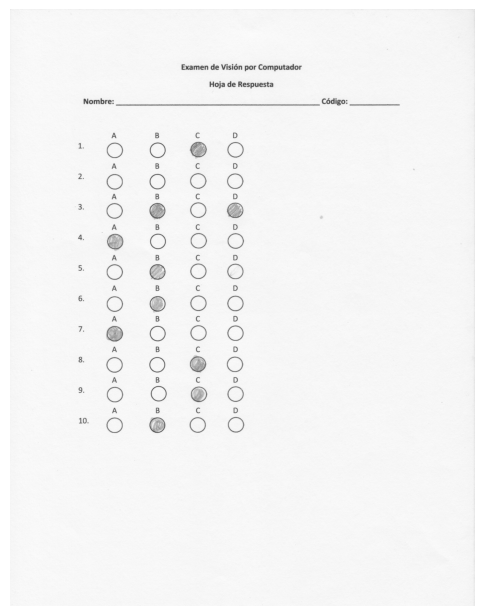

In [3]:
plot_img(img)

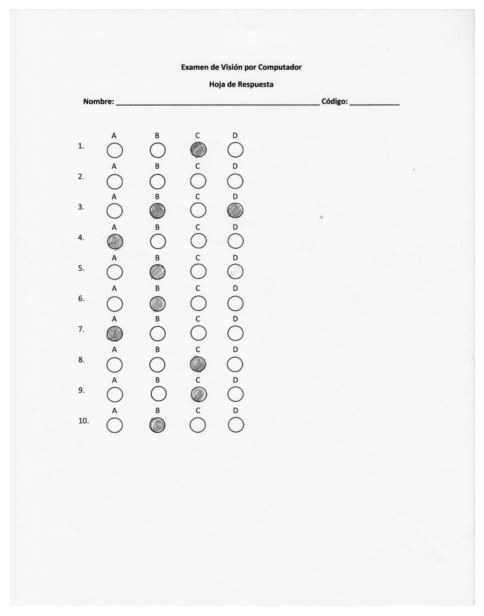

In [4]:
blur = cv.GaussianBlur(img, (7,7), 0)
plot_img(blur)

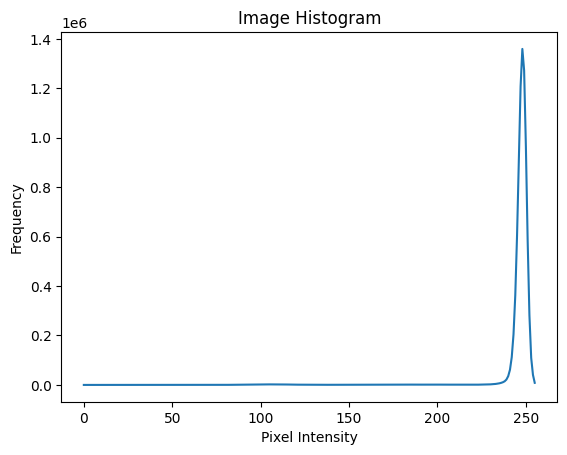

In [5]:
hist = cv.calcHist([img], [0], None, [256], [0, 256])
plt.plot(hist)
plt.title('Image Histogram')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency')
plt.show()

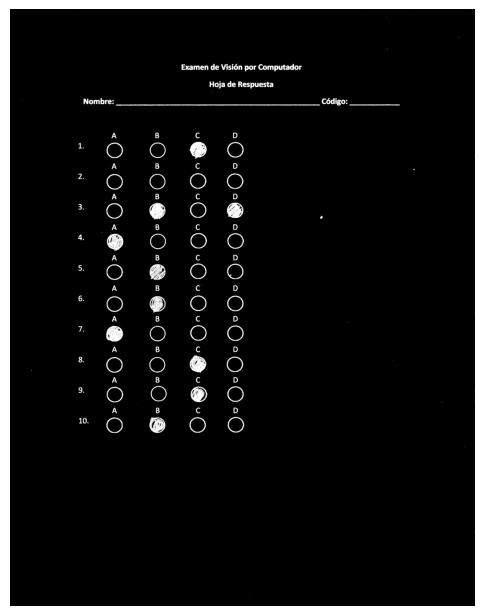

In [6]:
_, thresh = cv.threshold(img, 220, 255, cv.THRESH_BINARY)
th = cv.bitwise_not(thresh)
plot_img(th)

## Morphology

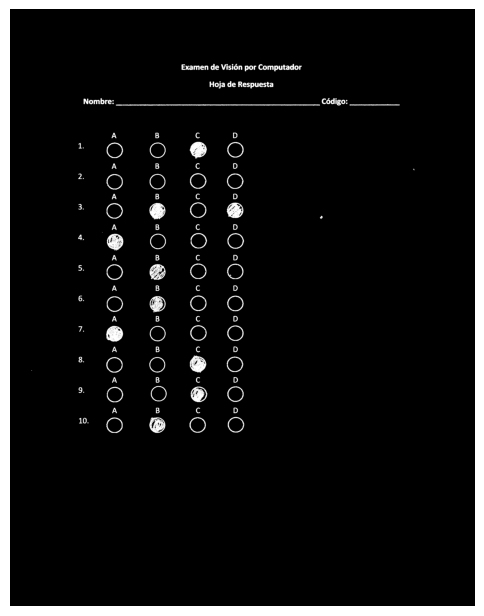

In [7]:
clean_kr = cv.getStructuringElement(cv.MORPH_ELLIPSE, (3,3))
clean = cv.morphologyEx(th, cv.MORPH_OPEN, clean_kr)
plot_img(clean)

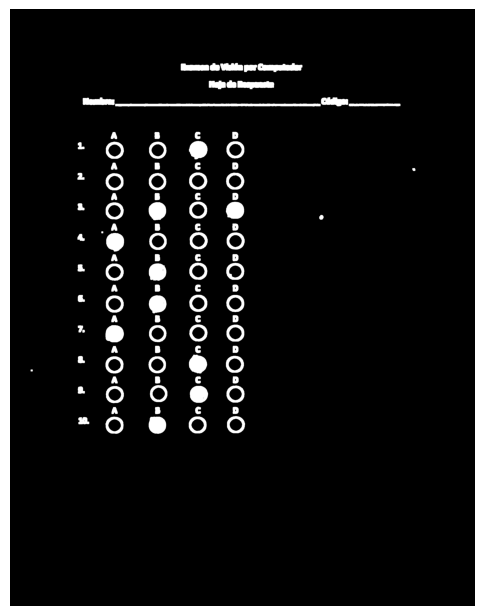

In [8]:
size = 3
kernel = np.ones((size, size), np.uint8)
dilate = cv.dilate(clean, kernel, iterations = 4)
plot_img(dilate)

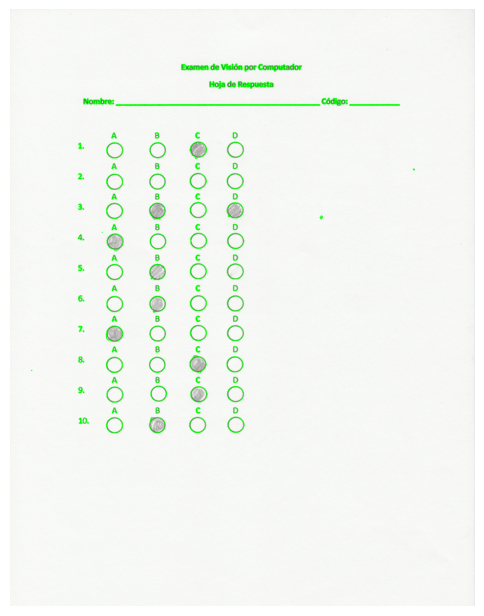

In [9]:
contours, _ = cv.findContours(clean, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
cnt_img = img_rgb.copy()
cnt = cv.drawContours(cnt_img, contours, -1, (0, 255, 0), 3)
plot_img(cnt)

In [10]:
areas_ls = []
for c in contours:
    area = cv.contourArea(c)
    areas_ls.append(area)

In [11]:
df_areas = pd.DataFrame(areas_ls, columns=['Area'])
df_areas.describe()

,Area
count,166.000000
mean,1702.891566
std,2403.221293
min,2.000000
25%,239.250000
50%,427.750000
75%,1136.875000
max,6166.500000


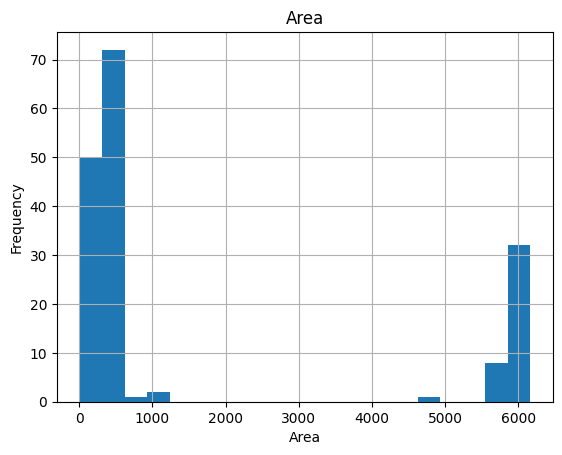

In [12]:
df_areas['Area'].hist(bins=20)
plt.title('Area')
plt.xlabel('Area')
plt.ylabel('Frequency')
plt.show()

In [13]:
bubbles = []
for cnt in contours:
    area = cv.contourArea(cnt)
    if 3000 < area < 7000:  
        x, y, w, h = cv.boundingRect(cnt)
        bubbles.append((x, y, w, h, cnt))

In [14]:
filled_bubbles = []
i = 0
for (x, y, w, h, cnt) in bubbles:
        mask = np.zeros(dilate.shape, dtype=np.uint8)
        cv.drawContours(mask, [cnt], -1, 255, -1)
        bit = cv.bitwise_and(dilate, dilate, mask=mask)

        total_area = cv.contourArea(cnt)
        filled_area = cv.countNonZero(bit)

        fill_ratio = filled_area / float(total_area)
        
        if 0.6 < fill_ratio < 1.03: #we can see this limits in the histogram
            filled_bubbles.append((x, y, w, h, cnt, fill_ratio, bit))
            
filled_bubbles_sorted = sorted(filled_bubbles, key=lambda y: y[1]) 

## Mask

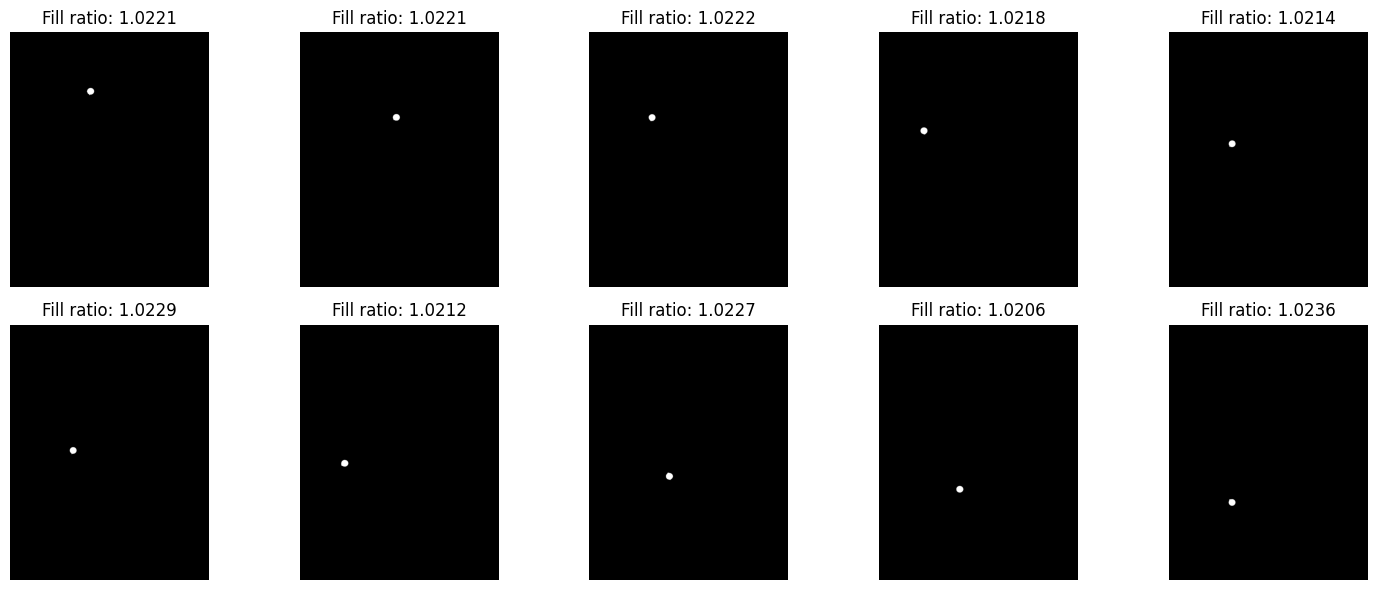

In [15]:
n_images = len(filled_bubbles)
cols = 5 
rows = (n_images // cols) + (1 if n_images % cols > 0 else 0)

fig, axes = plt.subplots(rows, cols, figsize=(15, 3 * rows))
axes = axes.flatten()

for i, (x, y, w, h, cnt, fill_ratio, bit) in enumerate(filled_bubbles_sorted):
    axes[i].imshow(bit, cmap='gray')
    axes[i].set_title(f"Fill ratio: {fill_ratio:.4f}")
    axes[i].axis('off') 

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

## Filter Rows and Columns

In [16]:
def to_rows(bubbles, n_rows = 10, Y_BIN_MARGIN = 6):
    centers_y = np.array([y + h/2 for (_, y, _, h, _, _, _) in bubbles])
    if len(centers_y) == 0:
        return [[] for _ in range(n_rows)]

    bins = np.linspace(centers_y.min() - Y_BIN_MARGIN, centers_y.max() + Y_BIN_MARGIN, n_rows + 1) #creates equally spaced along the vertical axis
    idxs = np.digitize(centers_y, bins) - 1  # 0..n_rows-1

    rows = [[] for _ in range(n_rows)]
    for idx, b in zip(idxs, bubbles):
        if 0 <= idx < n_rows:
            rows[idx].append(b)

    return rows

In [17]:
def compute_centers(bubbles, n_cols = 4, sep = 0.5):
    xs = [x + w/2 for (x, _, w, _, _, _, _) in bubbles]
    xmin, xmax = min(xs), max(xs)
    step = (xmax - xmin) / n_cols
    centers = [xmin + (i+sep)*step for i in range(n_cols)]
    return np.array(centers)

In [18]:
def normalize_rows(rows, centers):
    fill_idx = 5 #index of % fill in the bubbles
    rows_norm = []
    for r in rows:
        row_out = [None] * len(centers)   #[A, B, C, D]
        for cell in r:
            x,_, w, _,_,_,_ = cell
            cx = x + w/2
            c_idx = int(np.argmin(np.abs(centers - cx))) #finds the nearest column center
            if row_out[c_idx] is None or cell[fill_idx] > row_out[c_idx][fill_idx]: #it keeps only the one with the higher fill ratio
                row_out[c_idx] = cell
        rows_norm.append(row_out)
    return rows_norm


In [19]:
rows = to_rows(filled_bubbles_sorted)
centers = compute_centers(filled_bubbles_sorted)
rows_norm = normalize_rows(rows, centers)

In [20]:
def decide_answer(row, rel_thresh = 0.75, abs_min = 0.30):
    ratios = []
    for cell in row:
        ratios.append(0.0 if cell is None else float(cell[5]))

    max_val = max(ratios) if ratios else 0.0
    if max_val < abs_min:
        return "BLANK", ratios, [None if c is None else c[6] for c in row]

    cand = [i for i,v in enumerate(ratios) if v >= rel_thresh * max_val]

    if len(cand) == 1:
        return "ABCD"[cand[0]], ratios, [None if c is None else c[6] for c in row]
    else:
        return "INVALID", ratios, [None if c is None else c[6] for c in row]    

## Results

In [21]:
def draw_answers(img_rgb, rows, rows_norm, answers, show = True):
    abc = ['A', 'B', 'C', 'D']
    vis = img_rgb.copy()

    for r_idx, row in enumerate(rows):
        for c_idx, cell in enumerate(row):
            if cell is None:
                continue
            x, y, w, h, _, _, _ = cell
            cv.rectangle(vis, (x, y), (x + w, y + h), (0, 200, 0), 1)
            cv.putText(vis, f"{r_idx+1}-{abc[c_idx] if c_idx < len(abc) else '?'}", (x, y - 6), cv.FONT_HERSHEY_SIMPLEX, 0.4, (0, 150, 0), 1, cv.LINE_AA)

    n = min(len(answers), len(rows_norm))
    for r_idx in range(n):
        a = answers[r_idx]
        row = rows_norm[r_idx]

        row_cells = [c for c in row if c is not None]
        if not row_cells:
            continue 
        xr, yr, wr, hr, *_ = row_cells[0]

        if a in abc:
            c_idx = abc.index(a)
            cell = row[c_idx] if c_idx < len(row) else None
            if cell is None:
                cv.putText(vis, f"-> {a}*", (xr + wr + 8, yr + hr // 2),cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2, cv.LINE_AA)
                continue
            x, y, w, h, *_ = cell
            cv.rectangle(vis, (x - 2, y - 2), (x + w + 2, y + h + 2), (0, 0, 255), 2)
            cv.putText(vis, f"-> {a}", (x + w + 5, y + h // 2), cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2, cv.LINE_AA)
        else:
            cv.putText(vis, f"-> {a}", (xr + wr + 8, yr + hr // 2), cv.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2, cv.LINE_AA)

    if show:
        plot_img(vis)

    return vis

In [22]:
answers = []
row_details = [] 
for i, row in enumerate(rows_norm):
    choice, ratios, masks = decide_answer(row)
    print(f"row: {i}, choice: {choice}")
    answers.append(choice)
    row_details.append((ratios, masks))

row: 0, choice: C
row: 1, choice: BLANK
row: 2, choice: INVALID
row: 3, choice: A
row: 4, choice: B
row: 5, choice: B
row: 6, choice: A
row: 7, choice: C
row: 8, choice: C
row: 9, choice: B


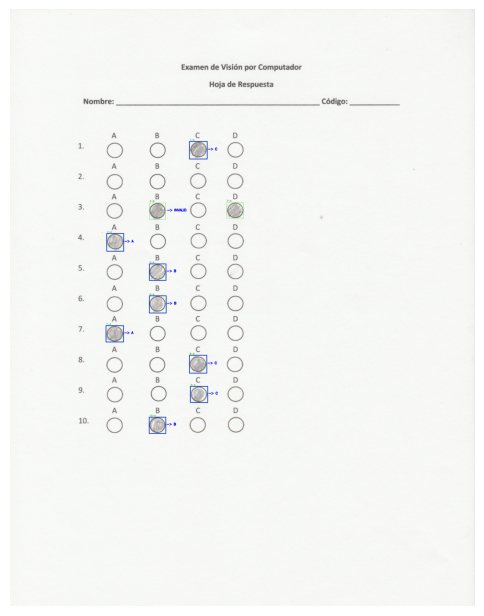

In [ ]:
vis = draw_answers(img_rgb, rows, rows_norm, answers, show = True)